# 0.0 Imports

In [42]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from IPython.display              import Image

In [2]:
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

# 1.0 Data Collection

### Database connection

In [3]:
# host = "comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com"
# port = 5432
# database = "comunidadedsdb"
# username = "member"
# password = "cdspa"

# conn = psycopg2.connect(
#             host=host,
#             port=port,
#             database=database,
#             user=username,
#             password=password
#         )

# cursor = conn.cursor()

### Getting existing tables from 'pa004' schema

In [4]:
# cursor.execute(
#     "SELECT tablename FROM pg_catalog.pg_tables WHERE schemaname NOT IN ('pg_catalog', 'information_schema', 'public');"
# )

# rows = cursor.fetchall()

# for row in rows:
#     print(row[0])

### Getting all data from 'users' table

In [5]:
# cursor.execute(
#     "SELECT * FROM pa004.insurance LIMIT 5"
# )

In [6]:
# for row in cursor.fetchall():
#     print(row)

### Getting tables as Pandas Dataframes

In [7]:
# df_users = pd.read_sql("SELECT * FROM pa004.users", conn)
# df_vehicle = pd.read_sql("SELECT * FROM pa004.vehicle", conn)
# df_insurance = pd.read_sql("SELECT * FROM pa004.insurance", conn)

In [8]:
# df_users.to_csv("./data/users.csv")
# df_vehicle.to_csv("./data/vehicle.csv")
# df_insurance.to_csv("./data/insurance.csv")

# 2.0 Data Loading

In [9]:
df_users = pd.read_csv("../data/users.csv")
df_users.drop("Unnamed: 0", axis=1, inplace=True)

df_vehicle = pd.read_csv("../data/vehicle.csv")
df_vehicle.drop("Unnamed: 0", axis=1, inplace=True)

df_insurance = pd.read_csv("../data/insurance.csv")
df_insurance.drop("Unnamed: 0", axis=1, inplace=True)

df_raw = pd.merge(pd.merge(df_users, df_vehicle, on='id'), df_insurance, on='id')

# 3.0 Data description and data cleaning

In [10]:
df1 = df_raw.copy()

## Data Dictionary

* <b> Id  </b> - Unique ID for the customer
* <b> Gender </b>  - Gender of the customer
* <b> Age </b> 	- Age of the customer
* <b> Driving_License </b>  - 0 : Customer does not have DL, 1 : Customer already has DL
* <b> Region_Code </b>  - Unique code for the region of the customer
* <b> Previously_Insured </b>  - 1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance
* <b> Vehicle_Age </b>  - Age of the Vehicle
* <b> Vehicle_Damage </b>  - 1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.
* <b> Annual_Premium </b>  - The amount customer needs to pay as premium in the year
* <b> Policy_Sales_Channel </b>  - Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
* <b> Vintage </b>  - Number of Days, Customer has been associated with the company
* <b> Response </b>  - 1 : Customer is interested, 0 : Customer is not interested

## 3.1 Data dimension

In [11]:
shape = df1.shape
print(f'Number of rows: {shape[0]}')
print(f'Number of columns: {shape[1]}')

Number of rows: 381109
Number of columns: 12


## 3.2 Data types

In [12]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

* We don't need to make any datatype changes.

## 3.3 Missing data

In [13]:
df1.isnull().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

* No missing data.

## 3.4 Duplicates

In [14]:
df1.duplicated().any()

False

* No duplicates.

## 3.5 Descriptive statistics

### 3.4.1 Numeric and categoric attributes

In [15]:
cat_columns = ['gender', 'region_code', 'policy_sales_channel', 'driving_license', 'vehicle_age', 
               'vehicle_damage', 'previously_insured', 'response']

num_columns = ['age', 'annual_premium', 'vintage']

In [16]:
cat_attributes = df1[cat_columns]
num_attributes = df1[num_columns]

### 3.4.2 Numeric attributes

#### Central Tendency

In [17]:
central_tendency = num_attributes.describe().loc[['mean', '50%']].T
central_tendency.rename(columns={'50%':'median'}, inplace=True)

#### Dispersion measures

In [18]:
dispersion = num_attributes.describe().loc[['min', 'max', 'std']].T
dispersion['range'] = dispersion.apply(lambda x: x['max'] - x['min'], axis=1)

#### Quantiles

In [19]:
quantiles = num_attributes.describe().loc[['25%', '75%']].T

#### Skewness & Kurtosis

In [20]:
skewness_kurtosis = pd.DataFrame()
skewness_kurtosis['skewness'] = num_attributes.apply(lambda x: x.skew())
skewness_kurtosis['kurtosis'] = num_attributes.apply(lambda x: x.kurtosis())

#### All metrics

In [21]:
numeric_metrics = pd.concat([central_tendency, dispersion, quantiles, skewness_kurtosis], axis=1)
numeric_metrics.reset_index(inplace=True)
numeric_metrics.rename(columns={'index':'attributes'}, inplace=True)
numeric_metrics = numeric_metrics[['attributes', 'mean', '25%', 'median', '75%', 'min', 'max', 'range', 'std', 'skewness', 'kurtosis']]

In [22]:
numeric_metrics

,attributes,mean,25%,median,75%,min,max,range,std,skewness,kurtosis
0,age,38.822584,25.0,36.0,49.0,20.0,85.0,65.0,15.511611,0.672539,-0.565655
1,annual_premium,30564.389581,24405.0,31669.0,39400.0,2630.0,540165.0,537535.0,17213.155057,1.766087,34.004569
2,vintage,154.347397,82.0,154.0,227.0,10.0,299.0,289.0,83.671304,0.003030,-1.200688


* annual_premium - o valor máximo é 540.000, enquanto o percentil 75 é 39.400, exibindo uma grande discrepância. Possivelmente essa variável possui outliers, que serão investigados posteriormente.

* annual_premium - um kurtosis de 34 indica que essa distribuição é extremamente empinada em relação a distribuição normal. Isso significa que os valores se concentram muito perto da média e que as caudas são pesadas,  o que significa que há uma alta probabilidade de valores extremos ou outliers.

### 3.4.3 Categoric attributes

#### Nº of categories for each cat col

In [23]:
cat_attributes.apply(lambda x: x.nunique())

gender                    2
region_code              53
policy_sales_channel    155
driving_license           2
vehicle_age               3
vehicle_damage            2
previously_insured        2
response                  2
dtype: int64

#### Frequency for each cat col

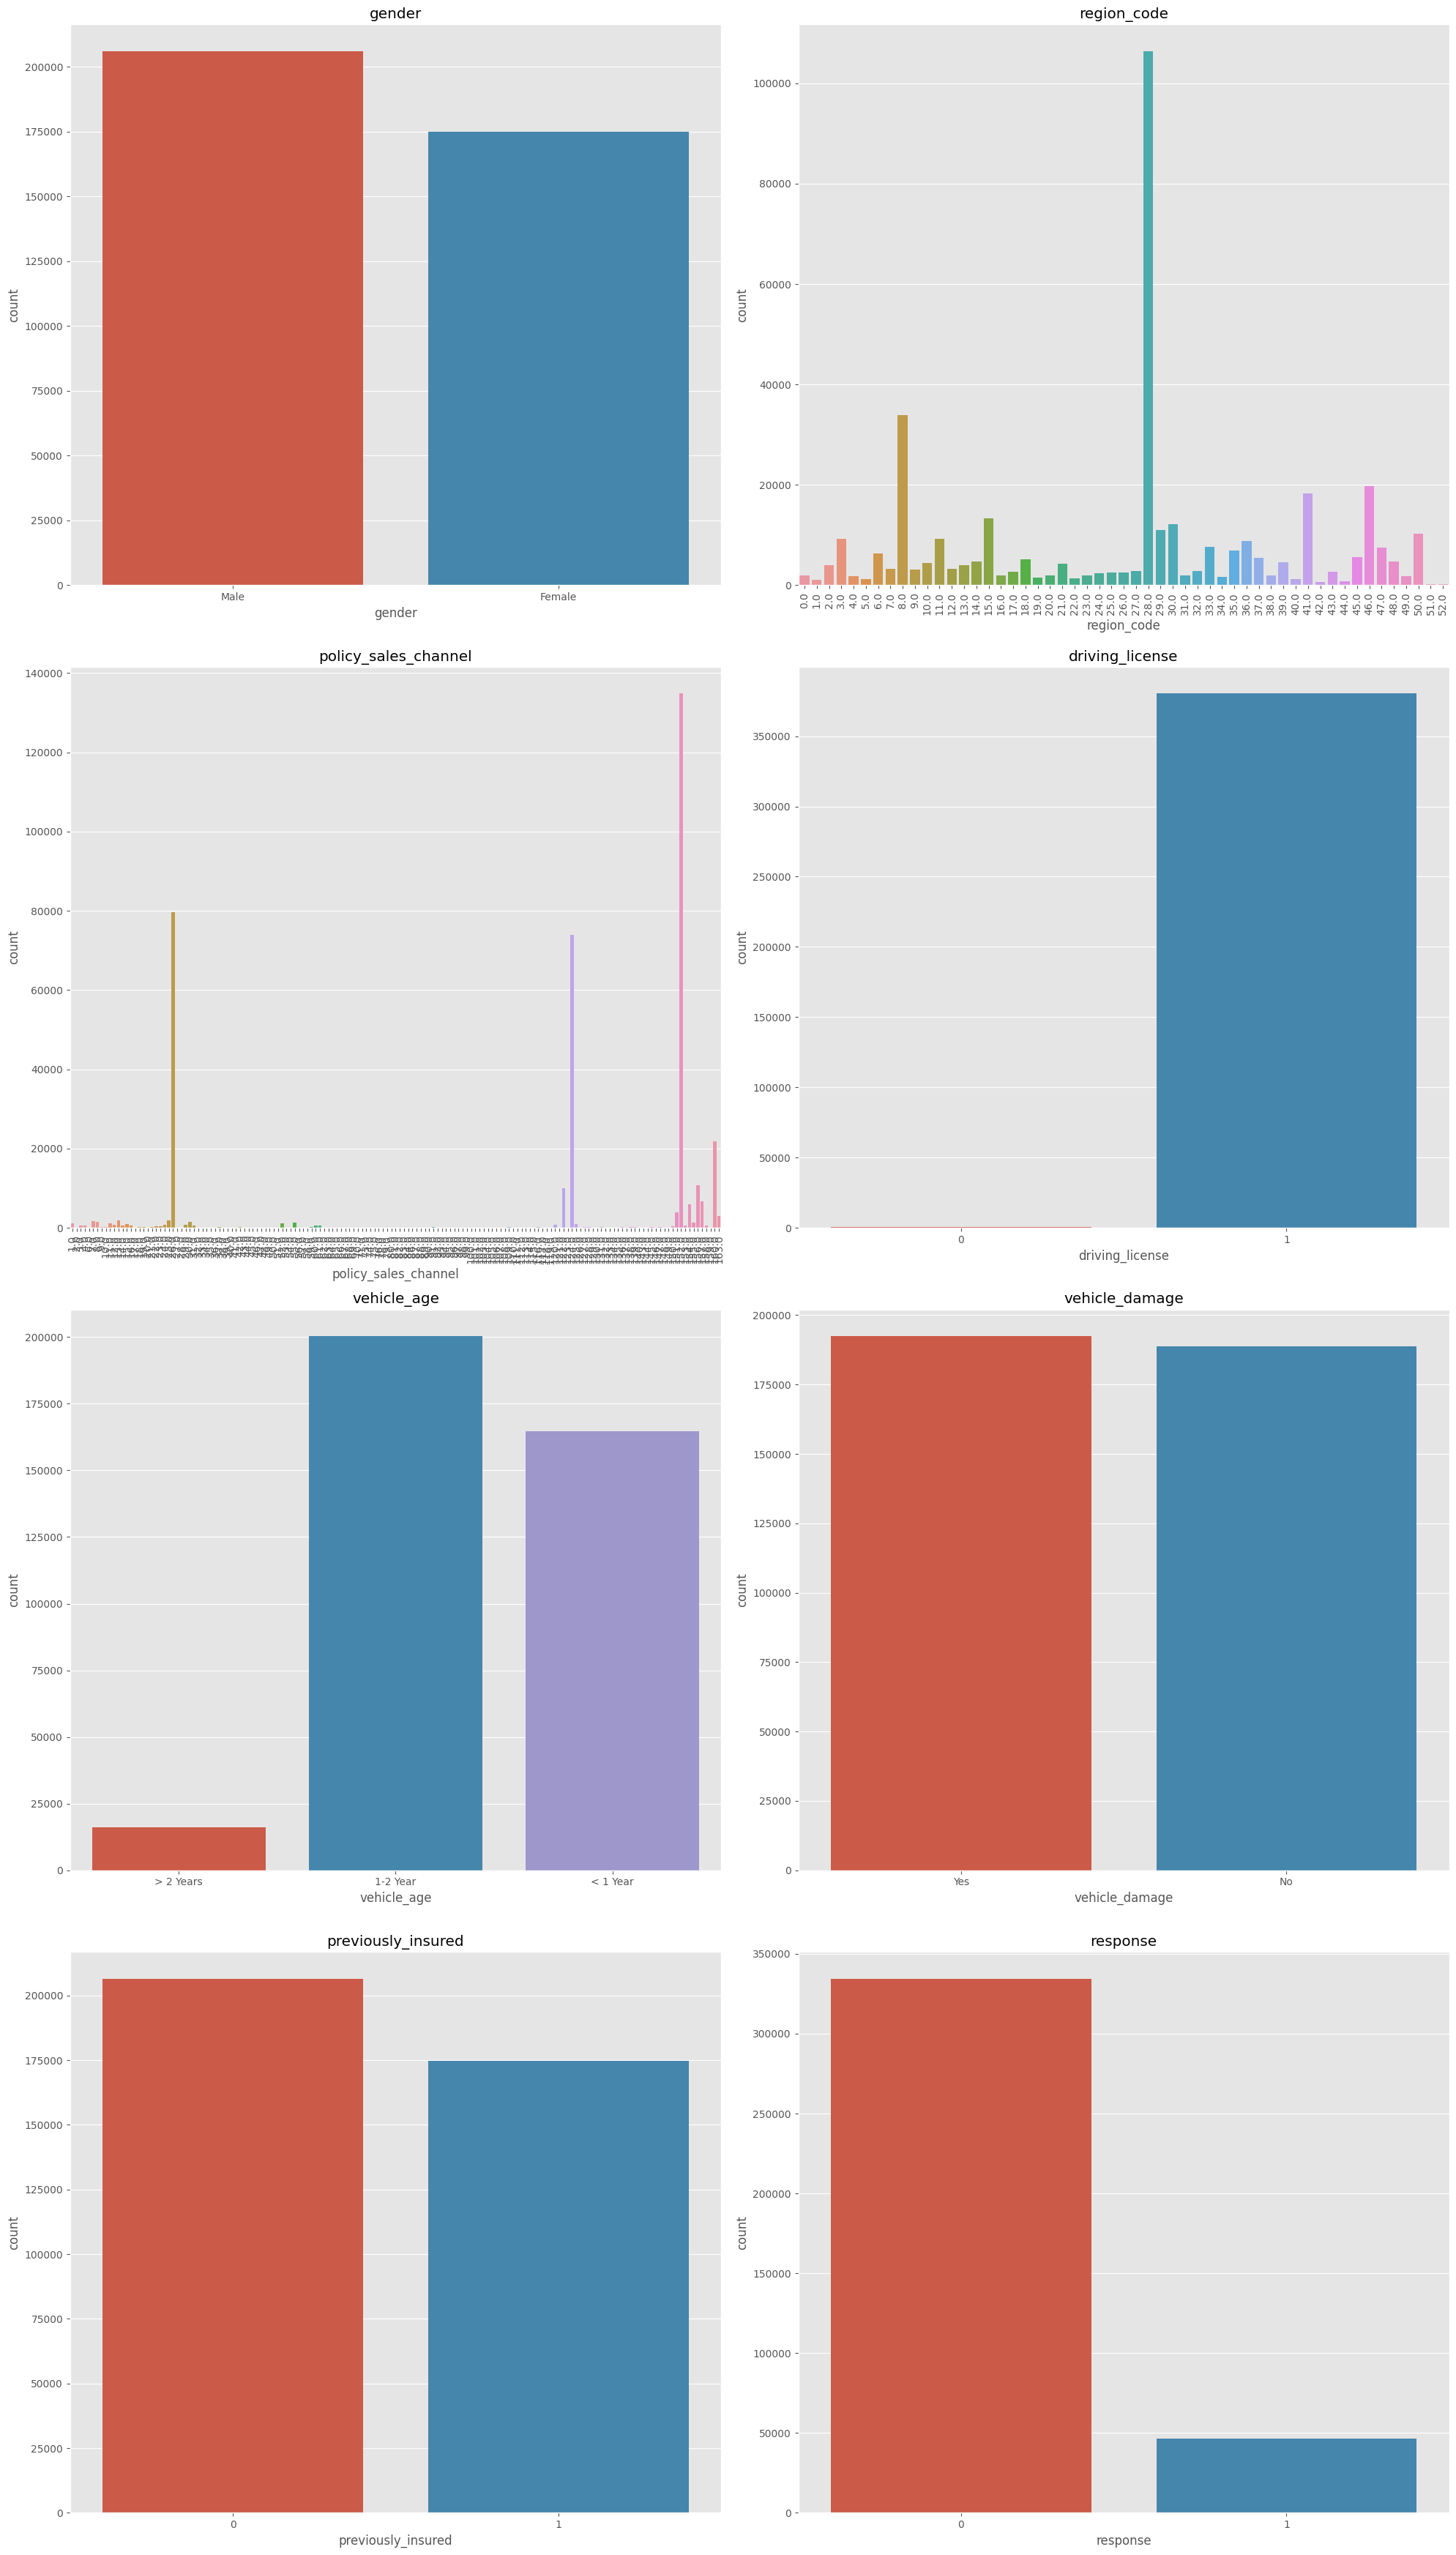

In [24]:
#quanto tem de cada categoria
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 35))

# Loop através das colunas do dataframe e plotagem dos gráficos
for i, column in enumerate(cat_attributes.columns):
    row = i // 2
    col = i % 2
    plot = sns.countplot(data=df1, x=column, ax=axes[row, col])
    axes[row, col].set_title(column)
    
    num_categories = len(df1[column].unique())
    if num_categories > 50:
        # Rotaciona as labels em 90 graus
        plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
        
# Exibição dos gráficos
plt.tight_layout()
plt.show()

#### Frequency for each cat col according to 'response'

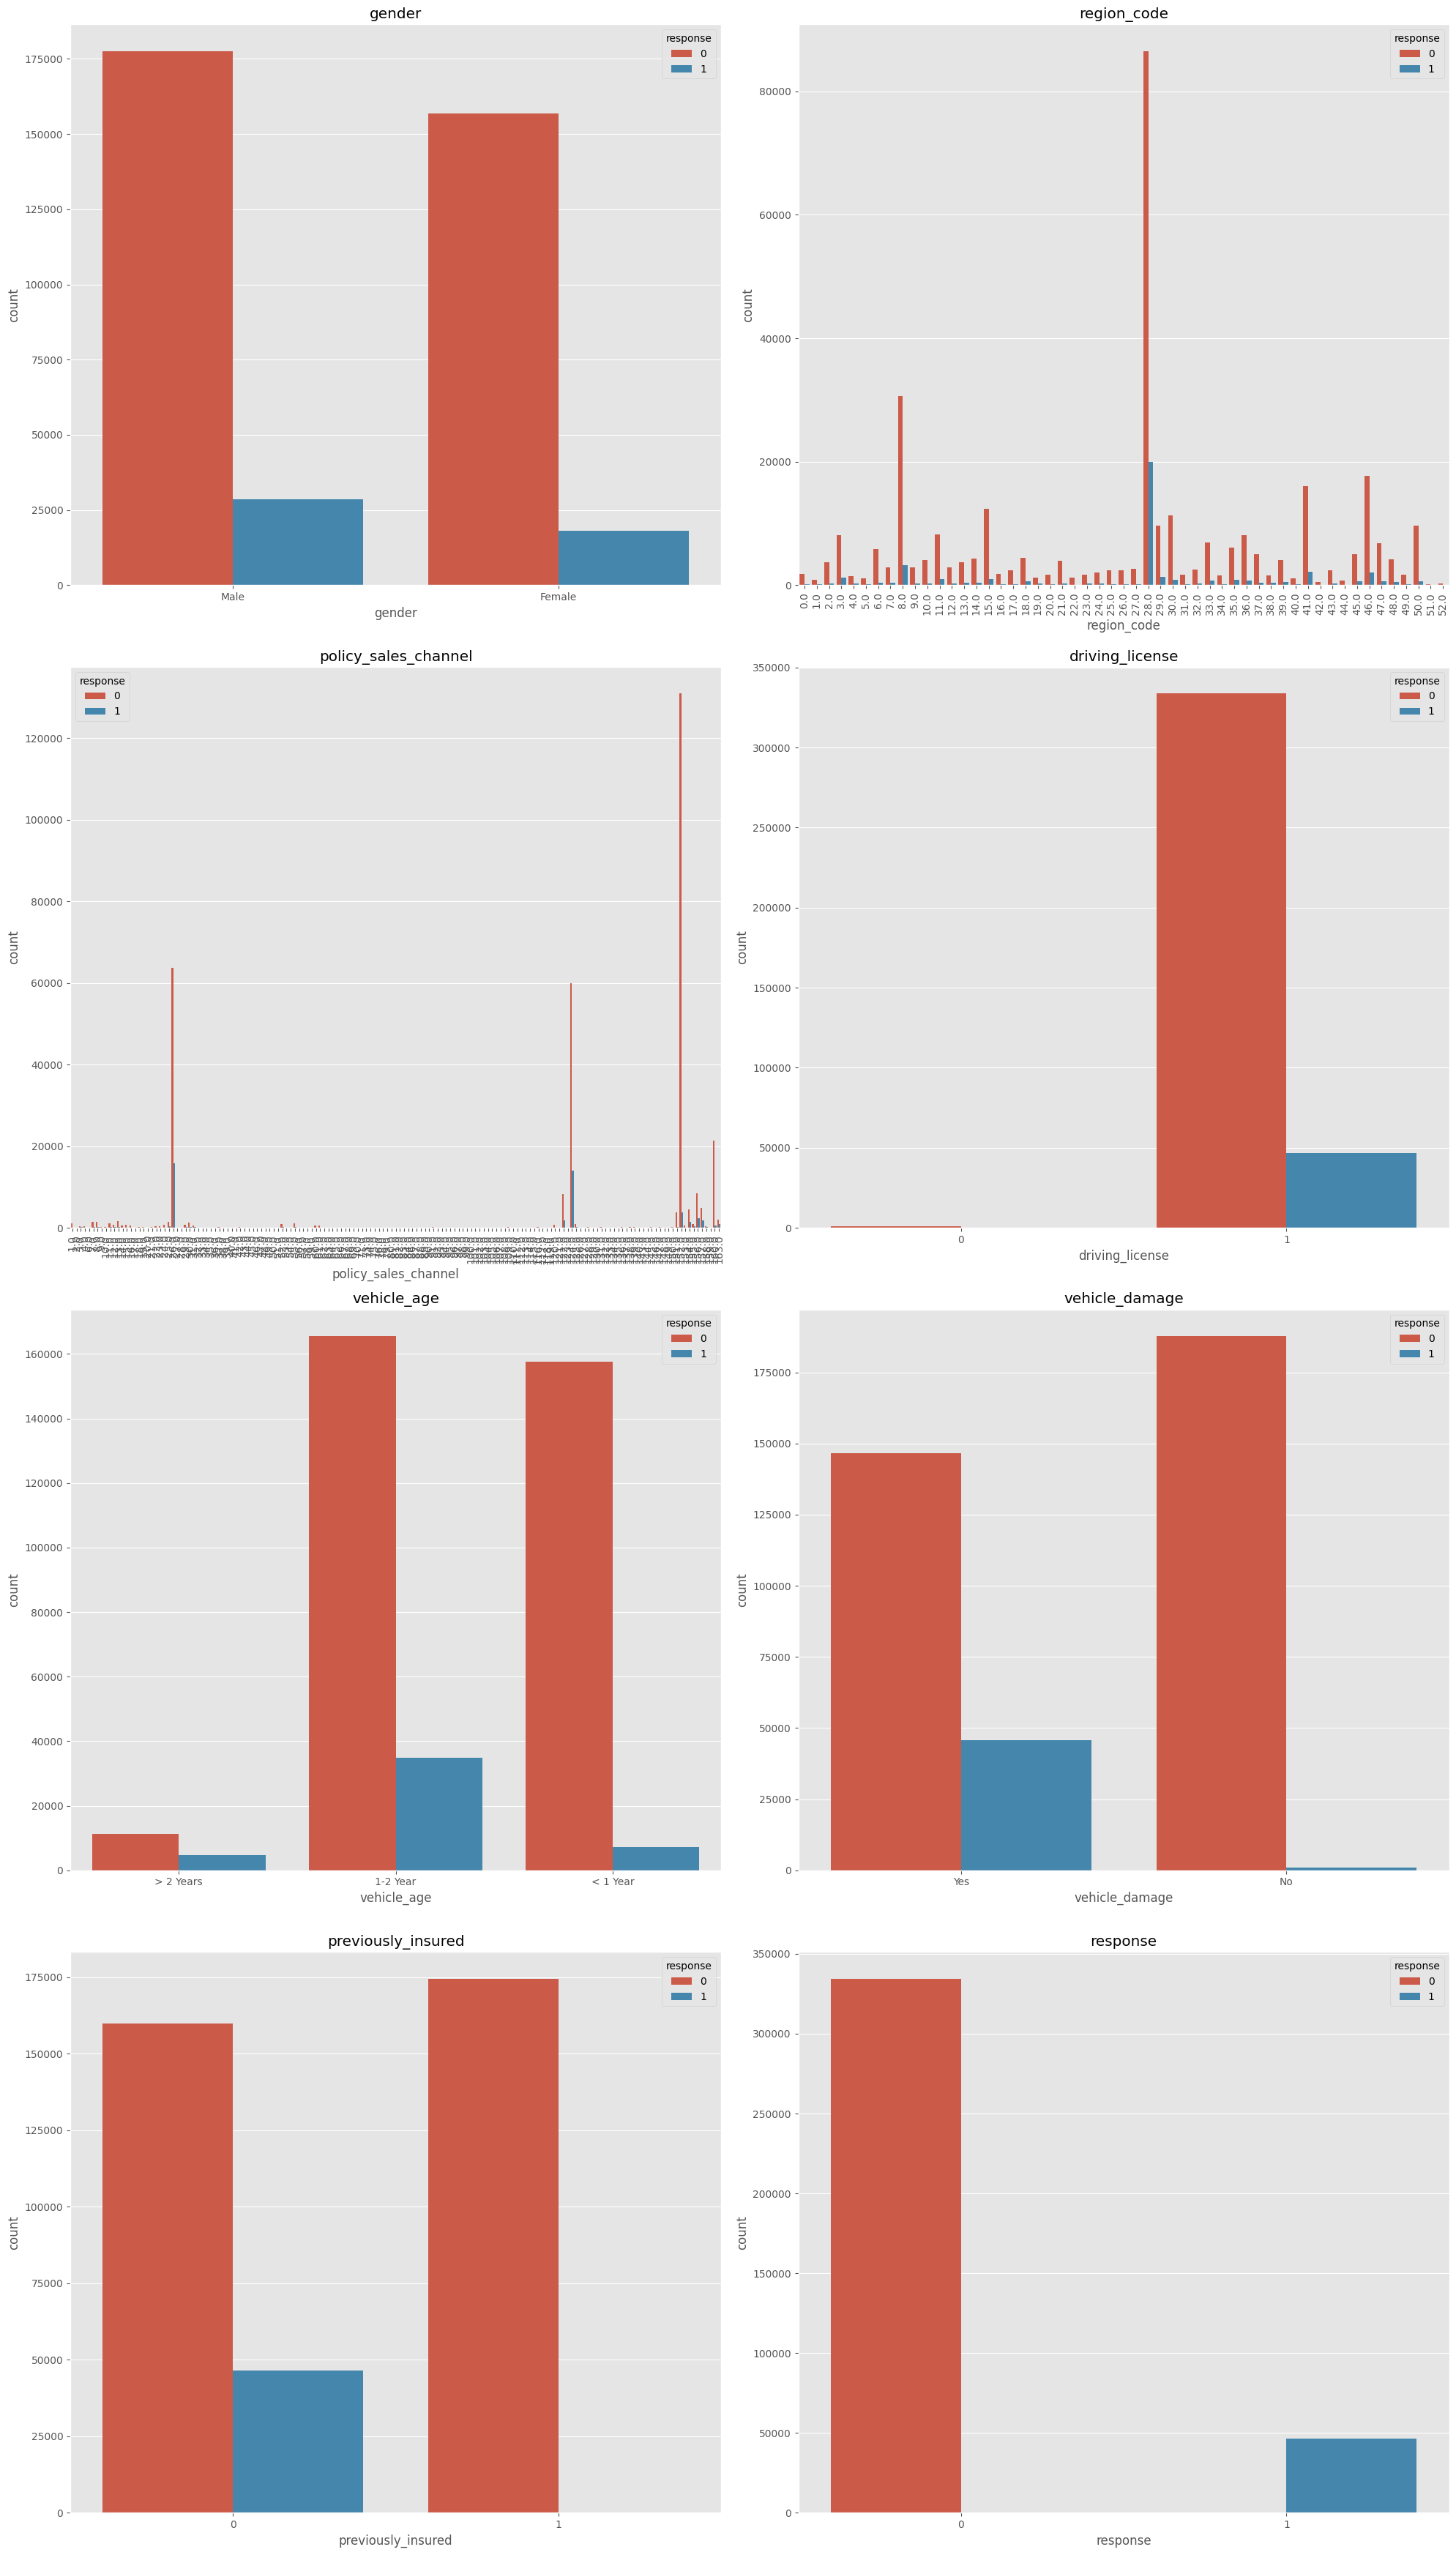

In [25]:
#quanto tem de cada categoria de acordo com a variável resposta
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 35))

# Loop através das colunas do dataframe e plotagem dos gráficos
for i, column in enumerate(cat_attributes.columns):
    row = i // 2
    col = i % 2
    plot = sns.countplot(data=df1, x=column, hue='response', ax=axes[row, col])
    axes[row, col].set_title(column)
    
    num_categories = len(df1[column].unique())
    if num_categories > 50:
        # Rotaciona as labels em 90 graus
        plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
        
# Exibição dos gráficos
plt.tight_layout()
plt.show()

## 3.6 Handling outliers

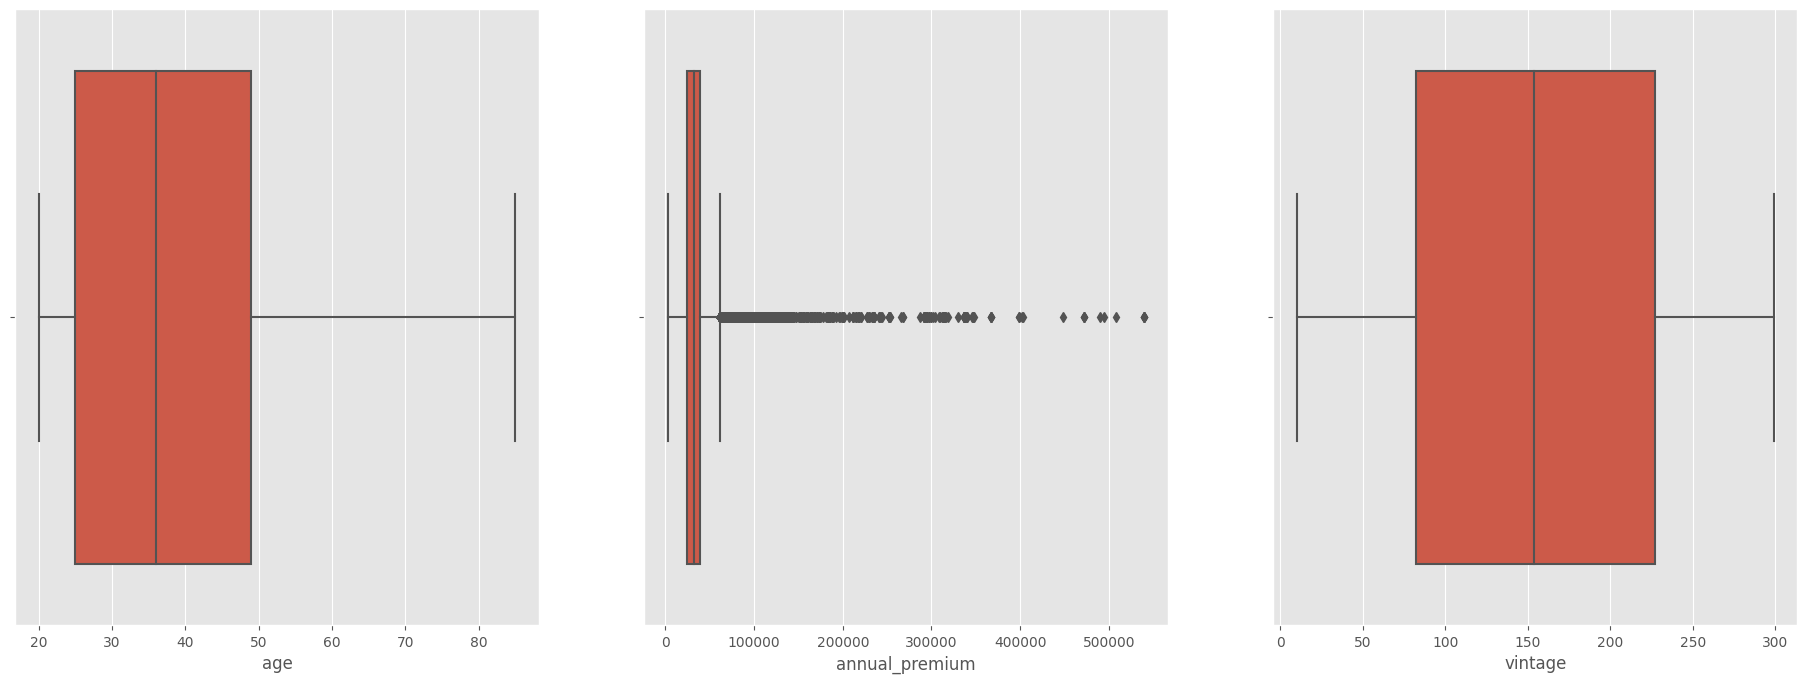

In [26]:
plt.figure(figsize=(23, 8))

plt.subplot(1, 3, 1)
sns.boxplot(data=df1, x='age')

plt.subplot(1, 3, 2)
sns.boxplot(data=df1, x='annual_premium')

plt.subplot(1, 3, 3)
sns.boxplot(data=df1, x='vintage')

plt.show()

Visually, we can see that we have outliers in 'annual_premium'. First, let's understand what this column exactly means.

* 'annual_premium': the amount customer needs to pay as premium in the year. A premium is a sum of money that the customer needs to pay regularly, in this case annualy, to an insurance company for this guarantee. 

Making some research, i checked that it is possible for a health insurer to have customers who pay different premium amounts, and the difference can be significant. This is because premiums are calculated based on a variety of factors, such as age, health history, type of plan purchased, geographic region, and more.

For example, a younger and healthier customer who purchases a basic plan may pay a much lower premium than an older and less healthy customer who purchases a more comprehensive plan. In addition, some companies may offer corporate health plans to their employees, which may have lower premiums than individual plans, or may be these records refers to someone contracting health insurance plans for all family members.

Therefore, it is normal for there to be a wide variation in premium values among the customers of a health insurer.

I will keep these outliers, but to make a better EDA, I'll create a 'annual_premium_transformed' column, in which i'll apply logarithmich transformation on 'annual_premium'.

In [34]:
df1['annual_premium_transformed'] = np.log(df1['annual_premium'])

# 4.0 Feature Engineering

## 4.1 Hypothesis mindmap

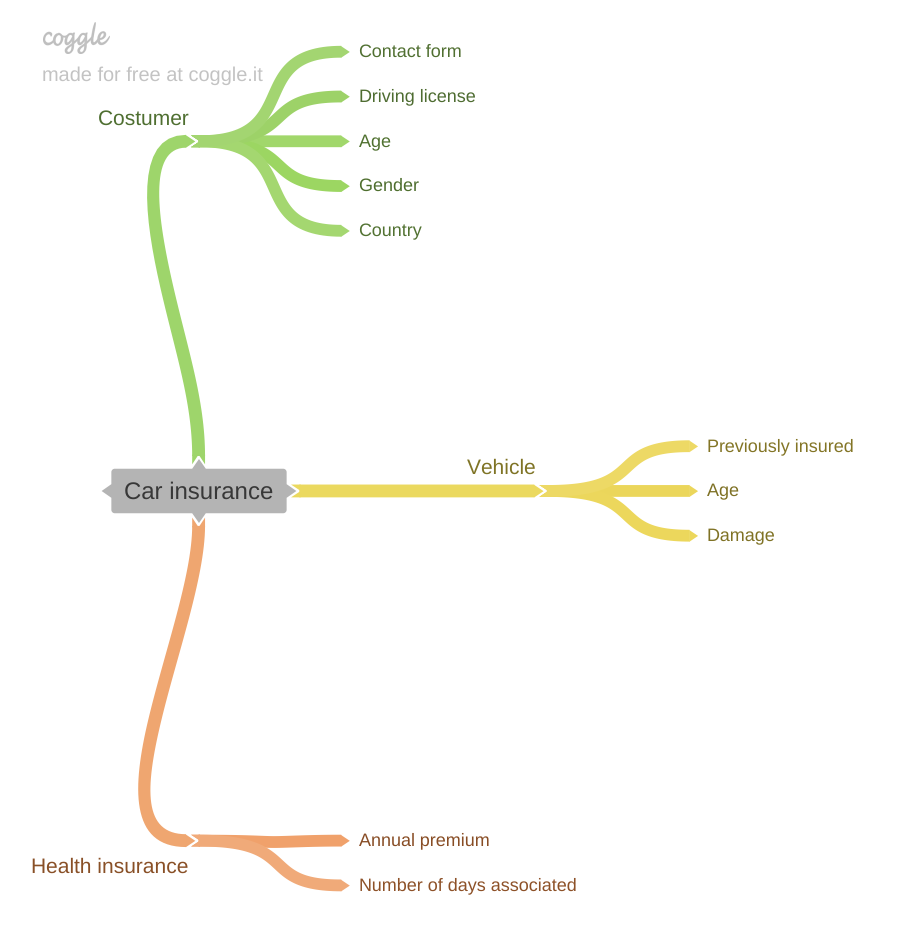

In [43]:
Image('../imgs/hypothesis_mindmap.png')